In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
import psycopg2

ubuntu=True

con = None

if ubuntu: 
    con = psycopg2.connect(database='mountainproject', password='kepler31', user='devin', port=5432, host='/var/run/postgresql/')
else:
    con = psycopg2.connect(database='mountainproject', user='User')
cur = con.cursor()
con.autocommit = True

In [148]:
data_set = 'star5'
useTFIDF = False
verbose = True

#Get raw data together

In [149]:
df_obs = pd.read_csv(data_set+'_observed_features.csv')
df_obs = df_obs.set_index('Climb')

In [150]:
q= '''
    SELECT climb_id, comment
    FROM comments;
    '''
cur.execute(q)
df_com = pd.DataFrame(cur.fetchall())
df_com.columns = ['climb_id', 'comment']
df_com.head()

comments_series = df_com.groupby(df_com.climb_id)['comment'].agg(lambda col: ' '.join(col))
comments_count = df_com.groupby(df_com.climb_id).count()
df_raw = df_obs.join(comments_series).join(comments_count, rsuffix='_count')
if verbose:
    print df_raw.head()

                location  rating  rating_dif  star_votes  stars  \
Climb                                                             
105834134           Utah   22.75         0.0           6    3.5   
106181256       Colorado   19.50         1.5          12    3.1   
105920111  International   17.50         0.0          13    2.9   
106208618     California   13.00         0.0          24    3.1   
105718117           Utah   28.00         0.5          45    4.9   

                     sub_location   type  \
Climb                                      
105834134           Wasatch Range   Trad   
106181256                 Boulder   Trad   
105920111           North America  Sport   
106208618  Yosemite National Park   Trad   
105718117      Zion National Park  Sport   

                                                     comment  comment_count  
Climb                                                                        
105834134  Neat route.  Roof on p2 is fantastically unbel...     

##TFIDF on comments

In [151]:
if useTFIDF:
    n_samples = 2000
    n_features = 1000
    n_topics = 4
    n_top_words = 10
    df_comment = pd.DataFrame(df_raw.comment).fillna('')


    #Make vectorizer and make sparse matrix of words
    comment_vectorizer = TfidfVectorizer(max_df=0.9, 
                                         min_df=0.05, 
                                         max_features=n_features,
                                         stop_words='english')
    comment_tfidf = comment_vectorizer.fit_transform(df_comment.comment)


    #Split the data and rain the model
    com_train, com_test, y_train, y_test = \
                        train_test_split(comment_tfidf,
                                         df_raw.stars, 
                                         test_size=0.2, 
                                         random_state=42)

    com_clas = RandomForestRegressor(n_estimators=200,
                                     n_jobs=-1).fit(com_train, 
                                                     y_train,)

    #Make new dataframe from tfidf predictions
    df_tfidf_pred = pd.DataFrame(
        com_clas.predict(
        comment_vectorizer.transform(df_comment.comment)
        )
        ).set_index(df_comment.index)
    df_tfidf_pred.columns=['tf_score']

In [152]:
if useTFIDF:
    if verbose:
    #Show results of model in predicting star rating

        com_y_pred = com_clas.predict(com_test)
        print "Mean Absolute Error:", mean_absolute_error(y_test, com_y_pred)
        print "Mean Squared Error:", mean_squared_error(y_test, com_y_pred)
        print ' '
        print df_tfidf_pred.head()

        n_words = 20
        features = comment_vectorizer.get_feature_names()
        feature_df = pd.DataFrame(com_clas.feature_importances_, index=features)
        feature_df.sort(0, inplace=True)
        feature_df.iloc[:n_words].plot(kind="barh",
                                       figsize=(8,10))
        legend = plt.legend()
        legend.remove()
        plt.xlabel('Word Importance')
        plt.show()

##Dummify and drop catagorical columns.

In [153]:
def dummify(df, col_names, drop_cols):
    #Make dummy columns from catagorical vars, and drop original
    for col_name in col_names:
        df = pd.concat([df, pd.get_dummies(df[col_name])], axis = 1).drop(col_name,1)
    for col in drop_cols:
        df=df.drop(col, 1)
    
    return df


In [154]:
df_raw.columns

Index([u'location', u'rating', u'rating_dif', u'star_votes', u'stars',
       u'sub_location', u'type', u'comment', u'comment_count'],
      dtype='object')

In [155]:
to_dum = ('type', 'sub_location')
to_drop = ['comment', 'location']
df = dummify(df_raw, to_dum, to_drop)

if useTFIDF:    
    df = pd.concat([df, df_tfidf_pred], axis=1)
if verbose:
    print df.head()

           rating  rating_dif  star_votes  stars  comment_count  Sport  TR  \
Climb                                                                        
105834134   22.75         0.0           6    3.5             15      0   0   
106181256   19.50         1.5          12    3.1              2      0   0   
105920111   17.50         0.0          13    2.9            NaN      1   0   
106208618   13.00         0.0          24    3.1              3      0   0   
105718117   28.00         0.5          45    4.9             23      1   0   

           Trad  *NH Ice and Alpine Climbing  Acadia National Park  \
Climb                                                                
105834134     1                            0                     0   
106181256     1                            0                     0   
105920111     0                            0                     0   
106208618     1                            0                     0   
105718117     0                  

In [156]:
targ = 'stars'
y = df[targ]
X = df.drop(targ, 1).fillna(0)

In [157]:
clas = RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [159]:
clas.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [160]:
clas.transform(X).shape

(13675, 20)

In [161]:
y_pred = clas.predict(X_test)

print mean_absolute_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred)

0.41595988642
0.280938533479


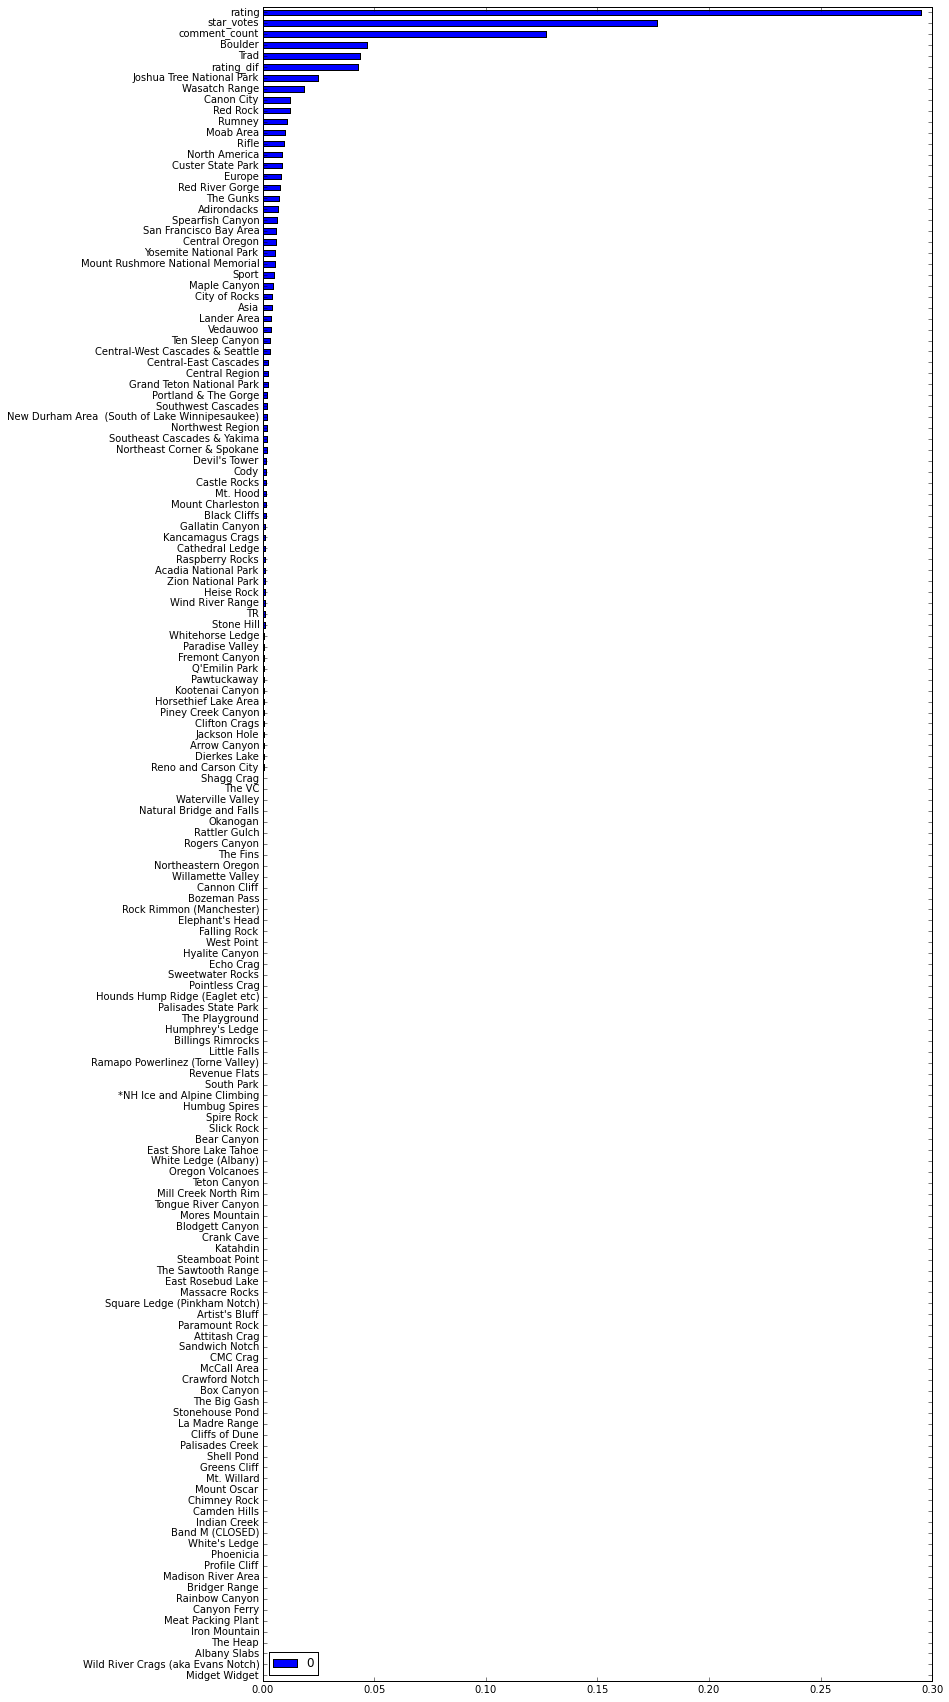

In [162]:
features = X.columns
feature_df = pd.DataFrame(clas.feature_importances_, index=features)
feature_df.sort(0, inplace=True)
# plt.figure(figsize=(20,20))
feature_df.plot(kind="barh", figsize=(12,30))
plt.show()

##Make a sample case

In [163]:
df_raw.columns

Index([u'location', u'rating', u'rating_dif', u'star_votes', u'stars',
       u'sub_location', u'type', u'comment', u'comment_count'],
      dtype='object')

In [164]:


df_raw.loc[df_raw['sub_location']=='The Gunks'].loc[df_raw['rating']>17].loc[df_raw['type'] == 'Trad']

,location,rating,rating_dif,star_votes,stars,sub_location,type,comment,comment_count
Climb,,,,,,,,,
105829266,New York,17.5,0.0,66,3.9,The Gunks,Trad,(beta alert &gt;&gt;) hand jam(s) help a lot. ...,11
105799049,New York,20.0,0.0,74,3.7,The Gunks,Trad,This climb is very pumpy for the grade but the...,15
105829767,New York,20.0,0.0,61,4.4,The Gunks,Trad,I think the description describes a variation ...,6
105899738,New York,19.5,0.0,33,4.0,The Gunks,Trad,Got the onsight lead on 5/2/2010. Excellent nu...,2
106391802,New York,22.5,-0.5,9,2.9,The Gunks,Trad,Easier than 5.11c as in guidebook. For taller ...,8
107333984,New York,24.5,0.5,5,3.6,The Gunks,Trad,NaN,NaN
105799072,New York,20.0,0.5,48,4.5,The Gunks,Trad,This excellent route is even better when climb...,13
106146799,New York,18.0,0.5,27,3.3,The Gunks,Trad,The crux takes one creative nut placement. Go...,4
106692049,New York,19.0,0.0,7,3.6,The Gunks,Trad,I led this once a long time ago. It was a coo...,1


In [195]:
def compare_change_sub_location(climb_id, origin, dest):
    climb_test = df.loc[climb_id].copy()
    print "Actual stars for climb:", y.loc[climb_id]
    climb_test.drop('stars', inplace=True)

    print "Model prediction of climb:", \
        clas.predict(X.loc[climb_id])[0],\
        origin
    climb_test = X.loc[climb_id].copy()
    climb_test[origin]=0
    climb_test[dest]=1
    print "Model prediction of climb if it were elsewhere:\n", \
        clas.predict(climb_test)[0], \
        dest



print '''
Example of hard sport climb:
Rumney is known for having awesome hard sport climbs, 
while Boulder is not.  
'''
compare_change_sub_location(105753604, 'Boulder', 'Rumney')



print '''
Example of easy Trad climb,
where the Gunks is better than Boulder:
The Gunks are known for their awesome and easy
sport routes.  Boulder is not.
'''

compare_change_sub_location(105748705, 'Boulder', 'The Gunks')


print '''
Example of hard Trad climb, 
where the Boulder is better than the Gunks:
Boulder is known for its awesome and harder
trad routes.  The Gunks are not.
'''
compare_change_sub_location(106391802, 'The Gunks', 'Boulder')




Example of hard sport climb:
Rumney is known for having awesome hard sport climbs, 
while Boulder is not.  

Actual stars for climb: 3.6
Model prediction of climb: 3.6675 Boulder
Model prediction of climb if it were elsewhere:
4.153 Rumney

Example of easy Trad climb,
where the Gunks is better than Boulder:
The Gunks are known for their awesome and easy
sport routes.  Boulder is not.

Actual stars for climb: 3.5
Model prediction of climb: 3.538 Boulder
Model prediction of climb if it were elsewhere:
4.14 The Gunks

Example of hard Trad climb, 
where the Boulder is better than the Gunks:
Boulder is known for its awesome and harder
trad routes.  The Gunks are not.

Actual stars for climb: 2.9
Model prediction of climb: 3.1285 The Gunks
Model prediction of climb if it were elsewhere:
3.264 Boulder


In [167]:
climb_ave = ((df.loc[105756532]+df.iloc[6])/2 ).drop('stars')
climb_ave

rating                                18.75
rating_dif                             0.25
star_votes                            61.50
comment_count                          6.00
Sport                                  1.00
TR                                     0.00
Trad                                   0.00
*NH Ice and Alpine Climbing            0.00
Acadia National Park                   0.00
Adirondacks                            0.00
Albany Slabs                           0.00
Arrow Canyon                           0.00
Artist's Bluff                         0.00
Asia                                   0.00
Attitash Crag                          0.00
Band M (CLOSED)                        0.00
Bear Canyon                            0.00
Billings Rimrocks                      0.00
Black Cliffs                           0.00
Blodgett Canyon                        0.00
Boulder                                0.50
Box Canyon                             0.00
Bozeman Pass                    

In [168]:
clas.predict(climb_ave)

array([ 3.667])

In [169]:
climb_ave['Moab Area'] = 0.
climb_ave['Zion National Park'] = 0.
climb_ave['Wasatch Range'] = 1.

In [170]:
clas.predict(climb_ave)

array([ 3.63])